In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import datetime
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt

/Users/Simran/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
total_labels = pd.read_csv('./input/dengue_labels_train.csv')
total_features = pd.read_csv('./input/dengue_features_train.csv')
total_test_features = pd.read_csv('./input/dengue_features_test.csv')
total_labels = total_labels.drop(total_labels.columns[[0, 1, 2]], axis=1) 

In [11]:
def preprocess_data(data_path, labels_path):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']

    return sj, iq

In [10]:
sj_train, iq_train = preprocess_data('./input/dengue_features_train.csv',
                                    './input/dengue_labels_train.csv')

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_dew_point_temp_k  station_avg_temp_c  \
city year weekofyear                                                    
sj   1990 18                           292.414286           25.442857   
          19                           293.951429           26.714286   
          20                           295.434286           26.714286   
          21                           295.310000           27.471429   
          22                           295.821429           28.942857   

                      station_min_temp_c  tota

In [335]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [336]:
for title in sj_train.columns.tolist()[:3]:
    sj_train_subtrain[title] = normalize(sj_train_subtrain[title])
    iq_train_subtrain[title] = normalize(iq_train_subtrain[title])
    sj_train_subtest[title] = normalize(sj_train_subtest[title])
    iq_train_subtest[title] = normalize(iq_train_subtest[title])

/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [328]:
sj_train_subtrain['new_feature'] = lagging_top_half(sj_train_subtrain['station_avg_temp_c'])
iq_train_subtrain['new_feature'] = lagging_top_half(iq_train_subtrain['station_avg_temp_c'])
sj_train_subtest['new_feature'] = lagging_top_half(sj_train_subtest['station_avg_temp_c'])
iq_train_subtest['new_feature'] = lagging_top_half(iq_train_subtest['station_avg_temp_c'])

/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [228]:
sj_train_subtrain['new_feature'] = top_half(sj_train_subtrain['station_avg_temp_c'])
iq_train_subtrain['new_feature'] = top_half(iq_train_subtrain['station_avg_temp_c'])
sj_train_subtest['new_feature'] = top_half(sj_train_subtest['station_avg_temp_c'])
iq_train_subtest['new_feature'] = top_half(iq_train_subtest['station_avg_temp_c'])

/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [184]:
sj_train_subtrain['new_feature'] = multiply(sj_train_subtrain['reanalysis_specific_humidity_g_per_kg'], sj_train_subtrain['reanalysis_dew_point_temp_k'])
iq_train_subtrain['new_feature'] = multiply(iq_train_subtrain['reanalysis_specific_humidity_g_per_kg'], iq_train_subtrain['reanalysis_dew_point_temp_k'])
sj_train_subtest['new_feature'] = multiply(sj_train_subtest['reanalysis_specific_humidity_g_per_kg'], sj_train_subtest['reanalysis_dew_point_temp_k'])
iq_train_subtest['new_feature'] = multiply(iq_train_subtest['reanalysis_specific_humidity_g_per_kg'], iq_train_subtest['reanalysis_dew_point_temp_k'])

/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [240]:
sj_train_subtest.columns.tolist()

['reanalysis_specific_humidity_g_per_kg',
 'reanalysis_dew_point_temp_k',
 'station_avg_temp_c',
 'station_min_temp_c',
 'total_cases',
 'new_feature']

In [245]:
print(sj_train_subtest)

                   reanalysis_specific_humidity_g_per_kg  \
year   weekofyear                                          
2005.0 37.0                                     1.000000   
       38.0                                     0.849655   
       39.0                                     0.881609   
       40.0                                     0.848506   
       41.0                                     0.774023   
       42.0                                     0.922529   
       43.0                                     0.927816   
       44.0                                     0.822989   
       45.0                                     0.805057   
       46.0                                     0.710115   
       47.0                                     0.534713   
       48.0                                     0.538391   
       49.0                                     0.206207   
       50.0                                     0.401609   
       51.0                             

In [338]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        
        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  21.7794117647
best alpha =  1e-08
best score =  6.34166666667


In [339]:
sj_test, iq_test = preprocess_data('./input/dengue_features_test.csv', None)

for title in sj_train.columns.tolist()[:3]:
    sj_test[title] = normalize(sj_test[title])
    iq_test[title] = normalize(iq_test[title])
    
sj_test['new_feature'] = lagging_top_half(sj_test['station_avg_temp_c'])
iq_test['new_feature'] = lagging_top_half(iq_test['station_avg_temp_c'])

    
sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv('./input/submission_format.csv',
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("./input/new_nbm.csv")

In [340]:
print(sj_predictions)

year  weekofyear
2008  18            25
      19            23
      20            31
      21            23
      22            26
      23            27
      24            31
      25            36
      26            39
      27            37
      28            33
      29            34
      30            41
      31            37
      32            49
      33            47
      34            48
      35            53
      36            59
      37            57
      38            48
      39            43
      40            53
      41            37
      42            38
      43            34
      44            30
      45            38
      46            33
      47            32
                    ..
2012  39            45
      40            45
      41            37
      42            55
      43            45
      44            49
      45            38
      46            37
      47            39
      48            30
      49            27
      50         

In [341]:
bench = np.concatenate([sj_predictions, iq_predictions])

In [121]:
testing = np.concatenate([sj_predictions, iq_predictions])

In [342]:
print(bench)

[25 23 31 23 26 27 31 36 39 37 33 34 41 37 49 47 48 53 59 57 48 43 53 37 38
 34 30 38 33 32 25 15 17 22 17 17 17 21 22 25 19 17 14 16 17 15 12 15 13 16
 18 20 22 19 25 24 39 33 32 36 33 38 43 42 47 49 40 42 43 46 45 50 43 42 48
 48 51 48 37 31 36 38 41 29 30 30 25 25 26 24 26 24 18 20 24 24 36 28 26 36
 27 21 21 28 44 44 31 37 41 57 53 46 48 52 56 62 53 53 51 57 51 56 58 57 55
 48 45 48 55 43 34 38 42 26 19 19 13 25 20 17 15 23 22 22 18 19 20 19 12 16
 11 14 22 26 18 19 18 25 17 31 40 41 45 62 59 53 47 49 43 50 44 60 51 53 52
 43 48 43 47 51 41 39 31 44 37 36 32 30 23 26 15 17 21 21 17 16 15 17 18 17
 18 19 16 15 19 23 23 22 19 29 26 37 34 26 39 36 39 43 40 43 42 45 41 45 53
 45 42 36 36 37 45 45 37 55 45 49 38 37 39 30 27 23 21 26 20 17 16 20 17 16
 16 16 18 13 12 25 23 26 24 22  6  5  8  2  2  4  6  5  6  6  6  5  4  5  4
  4  5  8 13  6  8  9  9 12  8  5  8  7  8  7  6  6  8  8  8  8  9  8  8 11
  8  8  8 10 10  5  9  9  7  6  8  5  7  7  3  4  5  4  4  6  2  3  5  6  6
  9  6  8 13

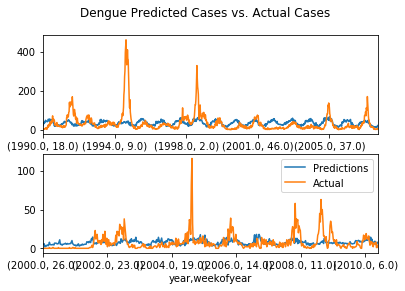

In [78]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()

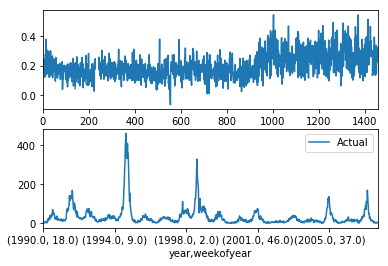

In [79]:
figs, axes = plt.subplots(nrows=2, ncols=1)
# station_diur_temp_rng_c, 
# plot sj
# print(sj_train['reanalysis_specific_humidity_g_per_kg'])

total_features.ndvi_sw.plot(ax=axes[0], label="...")

# sj_train.total_cases.plot(ax=axes[0], label="Actual")
# print(dir(sj_train))

sj_train.total_cases.plot(ax=axes[1], label="Actual")

# plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()

In [80]:
def normalize(column):
    new_column = []
    min_val = min(column)
    max_val = max(column)
    range_val = max_val-min_val
    for entry in column:
        new_column.append((entry-min_val)/range_val)
    return new_column

In [81]:
def multiply(column1, column2, column3=None):
    new_column = []
    for index in range(len(column1)):
        next_entry = column1[index]*column2[index]
        if column3 is not None:
            next_entry = next_entry*column3[index]
        new_column.append(next_entry)
    return new_column

In [162]:
def top_half(column):
    new_column = []
    for entry in column:
        if entry > .5:
            new_column.append(1)
        else:  new_column.append(0)
    return new_column

In [322]:
def lagging_top_half(column):
    delay = 2
    binary = top_half(column)
    new_column = []
    week_sum = sum(binary[:delay])
    for _ in range(delay):
        new_column.append(2.718**week_sum)
    for index in range(delay, len(column)):
        week_sum = sum(binary[index-delay:index])
        new_column.append(2.718**week_sum)
    return new_column